
#Show content of drive

In [ ]:
##get access google drive data into google colab 
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import warnings
warnings.filterwarnings('ignore')


#Unzip dataset


In [ ]:
from zipfile import ZipFile
file_name="/content/drive/My Drive/Leukemia_Calssifination_Augmented.zip"
with ZipFile(file_name,'r') as zip:
  zip.extractall()
  print('finish')

finish



Every notebook starts with the following three lines; they ensure that any edits to libraries you make are reloaded here automatically, and also that any charts or images displayed are shown in this notebook.

In [ ]:

%reload_ext autoreload
%autoreload 2
%matplotlib inline

#Necessary packages
We import all the necessary packages. The fastai library provides many useful functions that enable us to quickly and easily build neural networks and train our models.

In [ ]:
from fastai.vision import *
from fastai.callbacks.hooks import *
import gc
##from gradcam import *
import pandas as pd
import os

In [ ]:
image_data = Path('/content/Leukemia_Calssifination_Augmented')

In [ ]:
image_data.ls()

[PosixPath('/content/Leukemia_Calssifination_Augmented/CML'),
 PosixPath('/content/Leukemia_Calssifination_Augmented/ALL'),
 PosixPath('/content/Leukemia_Calssifination_Augmented/AML'),
 PosixPath('/content/Leukemia_Calssifination_Augmented/CLL'),
 PosixPath('/content/Leukemia_Calssifination_Augmented/Healthy')]

# Loading the data

In [ ]:
np.random.seed(24)
data = ImageDataBunch.from_folder(image_data, valid_pct=0.2, size = 224 , bs=64, num_workers=4).normalize(imagenet_stats)

In [ ]:
print(data.classes)
len(data.classes), data.c

['ALL', 'AML', 'CLL', 'CML', 'Healthy']


(5, 5)

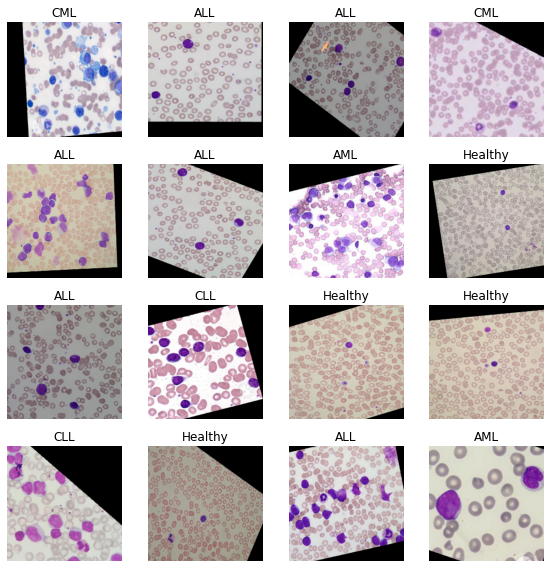

In [ ]:
data.show_batch(rows=4, figsize=(8,8))

# Training resnet34
We can now turn to train our model, In fastai, a model is trained using something called a “learner”.

**DataBunch**: A general fastai concept for data, and from there, there are subclasses for particular application like ImageDataBunch
**Learner:** A general concept for things that can learn to fit a model. From that, there are various subclasses to make things easier in particular, there is a convnet learner, which will create a convolutional neural network for us.

In [ ]:
learn = cnn_learner(data, models.resnet34, metrics = accuracy)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


In [ ]:
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

In [ ]:
learn.fit_one_cycle(10)

epoch,train_loss,valid_loss,accuracy,time
0,1.011991,0.330288,0.875776,04:26
1,0.455793,0.122228,0.957409,04:33
2,0.244108,0.073137,0.968944,04:33
3,0.127177,0.037640,0.985803,04:35
4,0.079334,0.036384,0.987578,04:37
5,0.065153,0.024723,0.988465,04:32
6,0.042691,0.017322,0.993789,04:24
7,0.027759,0.013497,0.997338,04:29
8,0.023320,0.012956,0.996451,04:35
9,0.016651,0.011831,0.996451,04:35


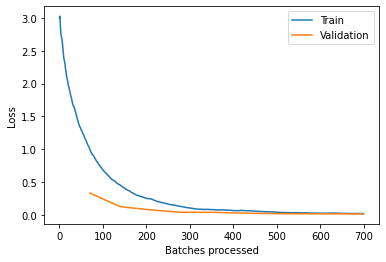

In [ ]:
learn.recorder.plot_losses() 

In [ ]:
learn.save("stage-1")

# Results
Let's see what results we have got.

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)

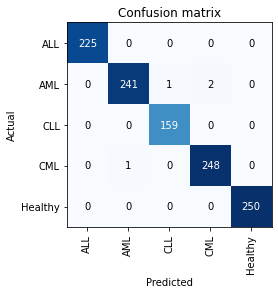

In [ ]:
interp.plot_confusion_matrix(figsize = (4,4))

In [ ]:
pred_path = Path('/content/drive/MyDrive/random_images')

In [ ]:
il = ImageList.from_folder(pred_path); il

ImageList (6 items)
Image (3, 1368, 1712),Image (3, 1944, 2592),Image (3, 720, 960),Image (3, 816, 960),Image (3, 645, 960)
Path: /content/drive/MyDrive/random_images

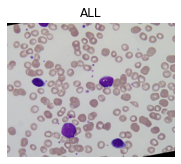

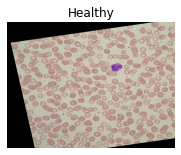

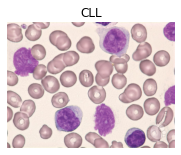

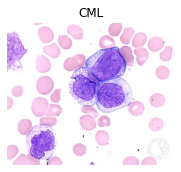

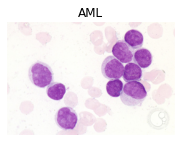

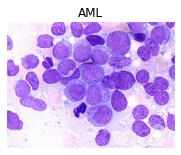

In [ ]:
for img in il:
   prediction = learn.predict(img)
   img.show(figsize=(3,3), title = str(prediction[0]))


In [ ]:
import scipy.ndimage

class GradCam():
    @classmethod
    def from_interp(cls,learn,interp,img_idx,ds_type=DatasetType.Valid,include_label=False):
        # produce heatmap and xb_grad for pred label (and actual label if include_label is True)
        if ds_type == DatasetType.Valid:
            ds = interp.data.valid_ds
        elif ds_type == DatasetType.Test:
            ds = interp.data.test_ds
            include_label=False
        else:
            return None
        
        x_img = ds.x[img_idx]
        xb,_ = interp.data.one_item(x_img)
        xb_img = Image(interp.data.denorm(xb)[0])
        probs = interp.preds[img_idx].numpy()

        pred_idx = interp.pred_class[img_idx].item() # get class idx of img prediction label
        hmap_pred,xb_grad_pred = get_grad_heatmap(learn,xb,pred_idx,size=xb_img.shape[-1])
        prob_pred = probs[pred_idx]
        
        actual_args=None
        if include_label:
            actual_idx = ds.y.items[img_idx] # get class idx of img actual label
            if actual_idx!=pred_idx:
                hmap_actual,xb_grad_actual = get_grad_heatmap(learn,xb,actual_idx,size=xb_img.shape[-1])
                prob_actual = probs[actual_idx]
                actual_args=[interp.data.classes[actual_idx],prob_actual,hmap_actual,xb_grad_actual]
        
        return cls(xb_img,interp.data.classes[pred_idx],prob_pred,hmap_pred,xb_grad_pred,actual_args)
    
    @classmethod
    def from_one_img(cls,learn,x_img,label1=None,label2=None):
        '''
        learn: fastai's Learner
        x_img: fastai.vision.image.Image
        label1: generate heatmap according to this label. If None, this wil be the label with highest probability from the model
        label2: generate additional heatmap according to this label
        '''
        pred_class,pred_idx,probs = learn.predict(x_img)
        label1= str(pred_class) if not label1 else label1
        
        xb,_ = learn.data.one_item(x_img)
        xb_img = Image(learn.data.denorm(xb)[0])
        probs = probs.numpy()
        
        label1_idx = learn.data.classes.index(label1)
        hmap1,xb_grad1 = get_grad_heatmap(learn,xb,label1_idx,size=xb_img.shape[-1])
        prob1 = probs[label1_idx]
        
        label2_args = None
        if label2:
            label2_idx = learn.data.classes.index(label2)
            hmap2,xb_grad2 = get_grad_heatmap(learn,xb,label2_idx,size=xb_img.shape[-1])
            prob2 = probs[label2_idx]
            label2_args = [label2,prob2,hmap2,xb_grad2]
            
        return cls(xb_img,label1,prob1,hmap1,xb_grad1,label2_args)
    
    def __init__(self,xb_img,label1,prob1,hmap1,xb_grad1,label2_args=None):
        self.xb_img=xb_img
        self.label1,self.prob1,self.hmap1,self.xb_grad1 = label1,prob1,hmap1,xb_grad1
        if label2_args:
            self.label2,self.prob2,self.hmap2,self.xb_grad2 = label2_args
            
    def plot(self,plot_hm=True,plot_gbp=True):
        if not plot_hm and not plot_gbp:
            plot_hm=True
        cols = 5 if hasattr(self, 'label2') else 3
        if not plot_gbp or not plot_hm:
            cols-= 2 if hasattr(self, 'label2') else 1

        fig,row_axes = plt.subplots(1,cols,figsize=(cols*5,5))  
        col=0
        size=self.xb_img.shape[-1]
        self.xb_img.show(row_axes[col]);col+=1
        
        label1_title = f'1.{self.label1} {self.prob1:.3f}'
        if plot_hm:
            show_heatmap(self.hmap1,self.xb_img,size,row_axes[col])
            row_axes[col].set_title(label1_title);col+=1
        if plot_gbp:
            row_axes[col].imshow(self.xb_grad1)
            row_axes[col].set_axis_off()
            row_axes[col].set_title(label1_title);col+=1
        
        if hasattr(self, 'label2'):
            label2_title = f'2.{self.label2} {self.prob2:.3f}'
            if plot_hm:
                show_heatmap(self.hmap2,self.xb_img,size,row_axes[col])
                row_axes[col].set_title(label2_title);col+=1
            if plot_gbp:
                row_axes[col].imshow(self.xb_grad2)
                row_axes[col].set_axis_off()
                row_axes[col].set_title(label2_title)
        # plt.tight_layout()
        fig.subplots_adjust(wspace=0, hspace=0)
        # fig.savefig('data_draw/both/gradcam.png')

def minmax_norm(x):
    return (x - np.min(x))/(np.max(x) - np.min(x))
def scaleup(x,size):
    scale_mult=size/x.shape[0]
    upsampled = scipy.ndimage.zoom(x, scale_mult)
    return upsampled

# hook for Gradcam
def hooked_backward(m,xb,target_layer,clas):
    with hook_output(target_layer) as hook_a: #hook at last layer of group 0's output (after bn, size 512x7x7 if resnet34)
        with hook_output(target_layer, grad=True) as hook_g: # gradient w.r.t to the target_layer
            preds = m(xb)
            preds[0,int(clas)].backward() # same as onehot backprop
    return hook_a,hook_g

def clamp_gradients_hook(module, grad_in, grad_out):
    for grad in grad_in:
        torch.clamp_(grad, min=0.0)
        
# hook for guided backprop
def hooked_ReLU(m,xb,clas):
    relu_modules = [module[1] for module in m.named_modules() if str(module[1]) == "ReLU(inplace)"]
    with callbacks.Hooks(relu_modules, clamp_gradients_hook, is_forward=False) as _:
        preds = m(xb)
        preds[0,int(clas)].backward()
        
def guided_backprop(learn,xb,y):
    xb = xb.cuda()
    m = learn.model.eval();
    xb.requires_grad_();
    if not xb.grad is None:
        xb.grad.zero_(); 
    hooked_ReLU(m,xb,y);
    return xb.grad[0].cpu().numpy()

def show_heatmap(hm,xb_im,size,ax=None):
    if ax is None:
        _,ax = plt.subplots()
    xb_im.show(ax)
    ax.imshow(hm, alpha=0.8, extent=(0,size,size,0),
              interpolation='bilinear',cmap='magma');

def get_grad_heatmap(learn,xb,y,size):
    '''
    Main function to get hmap for heatmap and xb_grad for guided backprop
    '''
    xb = xb.cuda()
    m = learn.model.eval();
    target_layer = m[0][-1][-1] # last layer of group 0
    hook_a,hook_g = hooked_backward(m,xb,target_layer,y)
    
    target_act= hook_a.stored[0].cpu().numpy()
    target_grad = hook_g.stored[0][0].cpu().numpy()
    
    mean_grad = target_grad.mean(1).mean(1)
#     hmap = (target_act*mean_grad[...,None,None]).mean(0)
    hmap = (target_act*mean_grad[...,None,None]).sum(0)
    hmap = np.where(hmap >= 0, hmap, 0)
    
    xb_grad = guided_backprop(learn,xb,y) # (3,224,224)        
    #minmax norm the grad
    xb_grad = minmax_norm(xb_grad)
    hmap_scaleup = minmax_norm(scaleup(hmap,size)) # (224,224)
    
    # multiply xb_grad and hmap_scaleup and switch axis
    xb_grad = np.einsum('ijk, jk->jki',xb_grad, hmap_scaleup) #(224,224,3)
    
    return hmap,xb_grad

In [ ]:
pred_path = Path('/content/drive/MyDrive/random_images')

In [ ]:
il = ImageList.from_folder(pred_path); il

ImageList (6 items)
Image (3, 1368, 1712),Image (3, 1944, 2592),Image (3, 720, 960),Image (3, 816, 960),Image (3, 645, 960)
Path: /content/drive/MyDrive/random_images

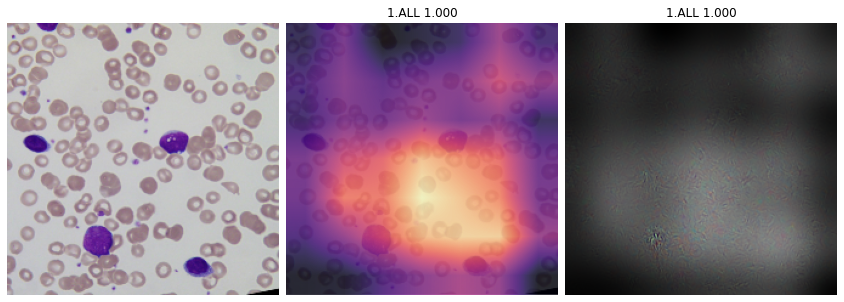

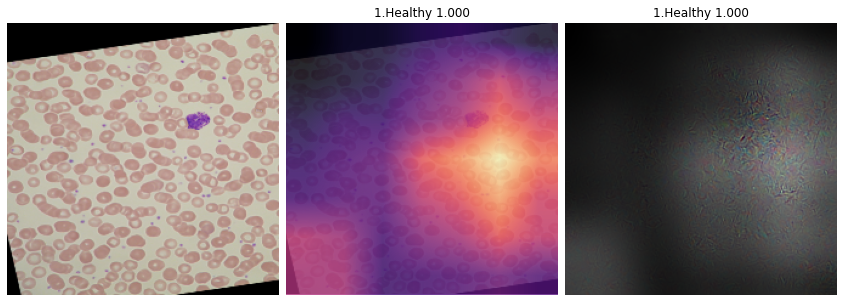

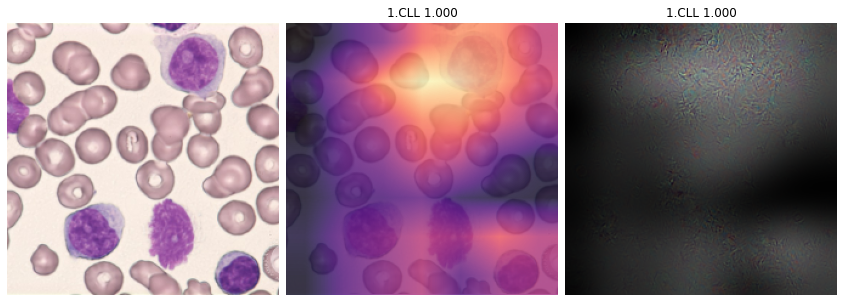

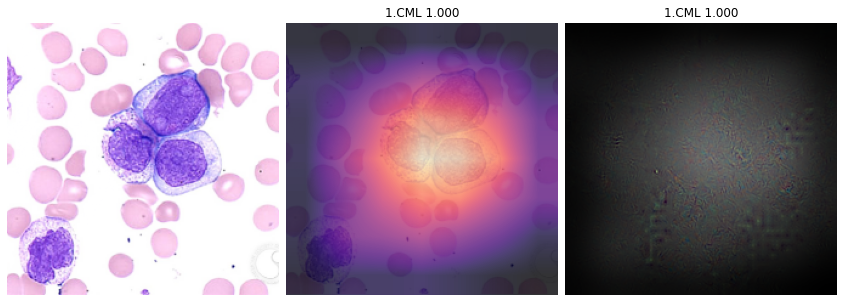

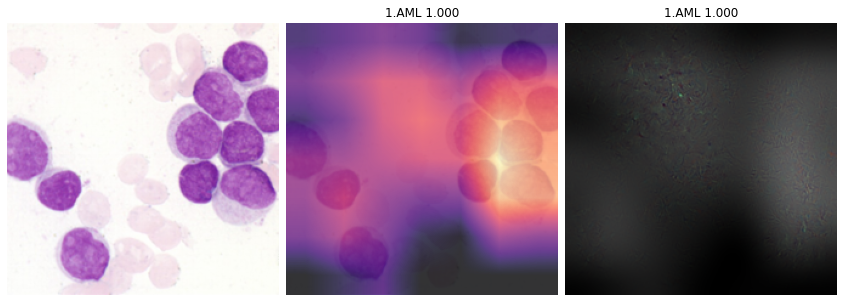

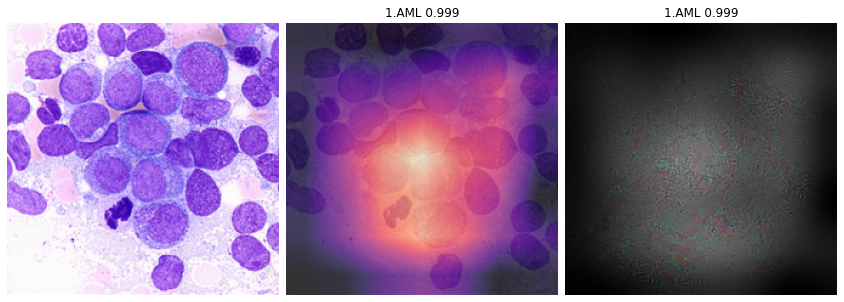

In [ ]:
for img in il:
    gcam = GradCam.from_one_img(learn, img)
    gcam.plot()  

In [ ]:
learn.path

PosixPath('/content/Leukemia_Calssifination_Augmented')

In [ ]:
learn.path= Path('')

In [ ]:
learn.path

PosixPath('.')

In [ ]:
learn.export('ResNet34.pkl')
